# Imbalanced Supervised Machine Learning
In this notebook, we train the following supervised ML models: 

- Logistic Regression

- Support Vector Machine classifier

- Random Forest classifier

- XGBoost classifier

- Light GBM classifier

- SMOTE with Random Forest

- Undersampling with Random Forest

The class distribution is 98 $\%$ majority class (non-fatal collisions) and 2 $\%$ minority class (fatal collisions). The optimizimation of the area under the receiver operating characteristic (AUROC) curve gives a slight improvement on the predictive power of the models.  SMOTE and Under Sampling techniques in combination with Random Forest classifier were applied on the training set, but they did not give any significant improvement on the imbalanced test set.

In [1]:
%matplotlib inline

# Ignore deprecated warning
import warnings
warnings.filterwarnings("ignore")

# Data manipulation
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set font scale and style
plt.rcParams.update({'font.size': 15})

# Resampling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Machine learning models
import lightgbm as lgb
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Grid search and model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Pickle
import joblib

In [2]:
# Import custom classes
%run -i '../src/helper/transfxn.py'
%run -i '../src/helper/imputer.py'
%run -i '../src/helper/ml.py'

In [3]:
# Instantiate the classes
transfxn = TransformationPipeline()
imputer = DataFrameImputer()
model = SupervisedModels()

# Load data

In [4]:
df = pd.read_csv('../data/feat_engr_data.csv') # Load cleaned data
print('Data size',df.shape) # data size
df.head()

Data size (6771768, 42)


,c_year,c_mnth,c_wday,c_hour,class,c_vehs,c_conf,c_rcfg,c_wthr,c_rsur,...,c_rcfg_ct,hour_ct_per_day_ct,hour_ct_per_month_ct,pisev_ct_per_hour_ct,conf_ct_per_hour_ct,psafe_ct_per_hour_ct,wthr_ct_per_hour_ct,vtype_ct_per_hour_ct,rcfg_ct_per_hour_ct,c_conf_ind
0,1999,January,Monday,20.0,0,2.0,Right turn,NaN,Clear and sunny,Icy,...,NaN,0.278072,0.434034,10.981478,0.268553,NaN,18.938386,0.772580,NaN,N
1,1999,January,Monday,20.0,0,2.0,Right turn,NaN,Clear and sunny,Icy,...,NaN,0.278072,0.434034,10.981478,0.268553,NaN,18.938386,22.330975,NaN,N
2,1999,January,Monday,20.0,0,2.0,Right turn,NaN,Clear and sunny,Icy,...,NaN,0.278072,0.434034,14.194474,0.268553,19.230057,18.938386,22.330975,NaN,N
3,1999,January,Monday,8.0,0,1.0,Hit a moving object,NaN,"Freezing rain, sleet, hail",Snow,...,NaN,0.391691,0.611380,7.796031,0.286598,NaN,0.098990,15.853328,NaN,N
4,1999,January,Monday,8.0,0,1.0,Hit a moving object,NaN,"Freezing rain, sleet, hail",Snow,...,NaN,0.391691,0.611380,10.077019,0.286598,NaN,0.098990,NaN,NaN,N


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6771768 entries, 0 to 6771767
Data columns (total 42 columns):
 #   Column                Dtype  
---  ------                -----  
 0   c_year                int64  
 1   c_mnth                object 
 2   c_wday                object 
 3   c_hour                float64
 4   class                 int64  
 5   c_vehs                float64
 6   c_conf                object 
 7   c_rcfg                object 
 8   c_wthr                object 
 9   c_rsur                object 
 10  c_raln                object 
 11  c_traf                object 
 12  v_id                  float64
 13  v_type                object 
 14  v_year                float64
 15  p_id                  float64
 16  p_sex                 object 
 17  p_age                 float64
 18  p_psn                 object 
 19  p_isev                object 
 20  p_safe                object 
 21  p_user                object 
 22  c_case                int64  
 23  wday_ct

# Class distribution

In [6]:
label_pct = df['class'].value_counts(normalize = True)*100
label_ct =  df['class'].value_counts()
pd.DataFrame({'labels': label_pct.index, 'count': label_ct.values, 'percentage': label_pct.values})

,labels,count,percentage
0,0,6659293,98.33906
1,1,112475,1.66094


# Descriptive statistics

In [7]:
df.drop(['class', 'p_id', 'v_id'], axis =1).describe()

,c_year,c_hour,c_vehs,v_year,p_age,c_case,wday_ct,mnth_ct,year_ct,hour_ct,...,v_type_ct,c_rcfg_ct,hour_ct_per_day_ct,hour_ct_per_month_ct,pisev_ct_per_hour_ct,conf_ct_per_hour_ct,psafe_ct_per_hour_ct,wthr_ct_per_hour_ct,vtype_ct_per_hour_ct,rcfg_ct_per_hour_ct
count,6.771768e+06,6.705458e+06,6.771201e+06,6.102074e+06,6.314556e+06,6.771768e+06,6.770404e+06,6.771343e+06,6.771768e+06,6.705458e+06,...,6.440489e+06,6.049634e+06,6.704640e+06,6.705314e+06,6.277187e+06,6.173829e+06,5.289712e+06,6.592229e+06,6.378820e+06,5.992100e+06
mean,2.007341e+03,1.370175e+01,2.047969e+00,1.999818e+03,3.673265e+01,1.273432e+06,9.770195e+05,5.698933e+05,3.618384e+05,3.848878e+05,...,4.852682e+06,2.665463e+06,3.975948e-01,6.819988e-01,1.141404e+01,3.281427e+00,1.518593e+01,1.237703e+01,1.740747e+01,9.500939e+00
std,5.453024e+00,5.166753e+00,1.244772e+00,7.690798e+00,1.850699e+01,7.423571e+05,9.878257e+04,5.374668e+04,4.404416e+04,1.566832e+05,...,1.856271e+06,7.545234e+05,1.673152e-01,2.877907e-01,1.052111e+01,3.790245e+00,1.459432e+01,1.381997e+01,1.771982e+01,8.795276e+00
min,1.999000e+03,0.000000e+00,1.000000e+00,1.901000e+03,1.000000e+00,1.000000e+00,8.113690e+05,4.526950e+05,2.898400e+05,4.484400e+04,...,9.490000e+02,6.340000e+02,3.888395e-02,7.117022e-02,7.629318e-02,2.307232e-02,2.321159e-05,2.952680e-02,1.573414e-03,1.051153e-03
25%,2.003000e+03,1.000000e+01,2.000000e+00,1.995000e+03,2.200000e+01,6.262348e+05,8.987790e+05,5.415500e+05,3.229840e+05,2.658360e+05,...,5.581069e+06,2.450279e+06,2.716118e-01,4.653258e-01,6.107406e+00,9.683758e-01,8.274048e+00,2.933946e+00,9.608269e+00,5.447381e+00
50%,2.007000e+03,1.400000e+01,2.000000e+00,2.000000e+03,3.500000e+01,1.271344e+06,9.571280e+05,5.932490e+05,3.685070e+05,4.257620e+05,...,5.581069e+06,3.164171e+06,3.991189e-01,7.092723e-01,8.145952e+00,2.283257e+00,1.126261e+01,1.028292e+01,1.307875e+01,7.265622e+00
75%,2.012000e+03,1.700000e+01,2.000000e+00,2.005000e+03,5.000000e+01,1.914787e+06,1.009002e+06,6.072220e+05,4.070360e+05,5.714810e+05,...,5.581069e+06,3.164171e+06,5.247452e-01,9.405052e-01,1.173846e+01,4.449727e+00,1.660501e+01,1.460244e+01,1.928263e+01,1.003723e+01
max,2.017000e+03,2.300000e+01,7.700000e+01,2.018000e+03,9.900000e+01,2.570235e+06,1.153278e+06,6.300950e+05,4.220750e+05,6.031470e+05,...,5.581069e+06,3.164171e+06,7.433695e-01,1.332347e+00,7.910878e+01,4.567360e+01,1.071731e+02,1.055476e+02,1.244552e+02,7.055952e+01


# Reduce Dataset
The dataset is very large to fit into memory, so training models on the entire dataset will take days to run let alone tuning the hyperparameters by grid search.  Hence, we will first split the dataset into two subsets and train the model on the small subset

In [8]:
X1, X2, y1, y2 = train_test_split(df, df['class'], test_size = 0.0015, random_state = 42, 
                                  stratify = df['class'])

In [9]:
print('Large subset size:', X1.shape, y1.shape)
print('Small subset size:', X2.shape, y2.shape)

Large subset size: (6761610, 42) (6761610,)
Small subset size: (10158, 42) (10158,)


In [10]:
# Pickle the small subset
X2.to_pickle('../data/collision.pkl')

# Prepare the Reduced Dataset for Machine Learning

In [4]:
# Reload the small subset
df_small = pd.read_pickle('../data/collision.pkl')

In [5]:
# Feature matrix and class label
cols_to_drop = ['c_case', 'p_id', 'v_id', 'class']
X, y = df_small.drop(cols_to_drop, axis = 1), df_small['class']

In [6]:
print('Data size:', X.shape, y.shape)

Data size: (10158, 38) (10158,)


# Create a test set
We now split the data set into $80\%$ training set and $20\%$ test set in a stratify fashion

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42, stratify = y)

In [8]:
print('Training set size:', X_train.shape, y_train.shape)
print('Test set size:', X_test.shape, y_test.shape)

Training set size: (8126, 38) (8126,)
Test set size: (2032, 38) (2032,)


In [9]:
print('Training set class distribution:\n', (y_train.value_counts()/X_train.shape[0])*100)
print('--' * 15)
print('Test set class distribution:\n', (y_test.value_counts()/X_test.shape[0])*100)

Training set class distribution:
 0    98.338666
1     1.661334
Name: class, dtype: float64
------------------------------
Test set class distribution:
 0    98.326772
1     1.673228
Name: class, dtype: float64


# Transformation pipeline

## 1. Impute missing values

In [10]:
# Fit transform the training set
X_train_imputed = imputer.fit_transform(X_train)

# Only transform the test set
X_test_imputed = imputer.transform(X_test)

## 2. Pre-processing

In [11]:
# Transform and scale data
X_train_scaled, X_test_scaled, feat_names = transfxn.preprocessing(X_train_imputed, X_test_imputed)

In [12]:
# Size of the data after pre-processing
print('Training set size after pre-processing:', X_train_scaled.shape)
print('Test set size after pre-processing:', X_test_scaled.shape)

Training set size after pre-processing: (8126, 153)
Test set size after pre-processing: (2032, 153)


In [13]:
# Convert the class labels to arrays
y_train, y_test = y_train.values,  y_test.values

# A. Model Selection by Cross-Validation

## A-1. Logistic Regression

In [21]:
log_clf = LogisticRegression(random_state=42)   
model.eval_metrics_cv(log_clf, X_train_scaled, y_train, cv_fold = 10, scoring = 'accuracy',
                      model_nm = "Logistic Regression")

10-Fold cross-validation results for Logistic Regression
------------------------------------------------------------
Accuracy (std): 0.990524 (0.001354)
AUROC: 0.834198
AUPRC: 0.531159
Predicted classes: [0 1]
Confusion matrix:
 [[7991    0]
 [  77   58]]
Classification report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      7991
           1       1.00      0.43      0.60       135

    accuracy                           0.99      8126
   macro avg       1.00      0.71      0.80      8126
weighted avg       0.99      0.99      0.99      8126

------------------------------------------------------------


## A-1-1.  Hyperparameter tuning - LR
 In this section, we shall optimize the **AUC** of the classifiers using grid/randomized search, cross-validation, and cost sensitive method

In [14]:
# Class ratio of the 
# negative class to the positive class
neg = y_train == 0
pos = y_train == 1
class_ratio = np.sum(neg)/np.sum(pos)
class_ratio

59.19259259259259

In [23]:
# Range of hyperparameters
params = {'C': [2**x for x in range(-2,5,2)],
           'class_weight': ['balanced', None, {0:1, 1:class_ratio}]
            }
                             
# Grid search
log_clf = LogisticRegression()   
gsearch_log = RandomizedSearchCV(estimator = log_clf, param_distributions = params, 
                                scoring = 'roc_auc', cv = 10, n_jobs = -1, 
                                n_iter = 200, random_state = 42, verbose = 1)

# Fit the training set
gsearch_log.fit(X_train_scaled, y_train)

# Pickle trained model
joblib.dump(gsearch_log.best_estimator_, '../src/model/log_clf.pkl')

# Print results
print('Best AUC score:', gsearch_log.best_score_)
print('Best parameters:', gsearch_log.best_params_)    

Fitting 10 folds for each of 12 candidates, totalling 120 fits
Best AUC score: 0.8483006024013534
Best parameters: {'class_weight': None, 'C': 16}


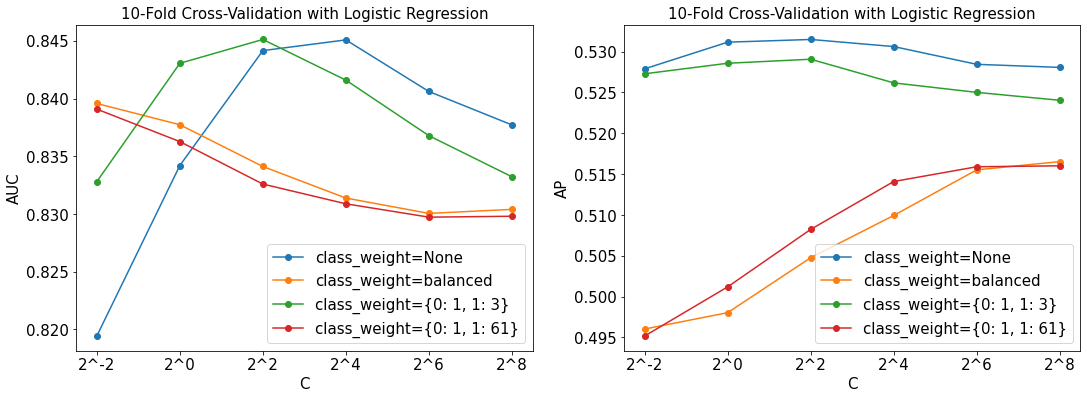

In [24]:
model.plot_auc_ap_lr(X_train_scaled, y_train, cv_fold = 10)

## A-2. Support Vector Machine

In [25]:
svm_clf = SVC(probability = True, kernel = 'rbf', random_state=42)   
model.eval_metrics_cv(svm_clf, X_train_scaled, y_train, cv_fold = 10, scoring = 'accuracy', 
                      model_nm = "SVM Classifier")

10-Fold cross-validation results for SVM Classifier
------------------------------------------------------------
Accuracy (std): 0.990524 (0.001354)
AUROC: 0.812404
AUPRC: 0.498294
Predicted classes: [0 1]
Confusion matrix:
 [[7991    0]
 [  77   58]]
Classification report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      7991
           1       1.00      0.43      0.60       135

    accuracy                           0.99      8126
   macro avg       1.00      0.71      0.80      8126
weighted avg       0.99      0.99      0.99      8126

------------------------------------------------------------


## A-2-1. Hyperparameter tuning- SVM

In [15]:
# Range of hyperparameters
params = {'C': [2**x for x in range(-2,8,2)], 
          'gamma': [2**x for x in range(-11,1,2)],
          'class_weight': ['balanced', None, {0:1, 1:class_ratio}]
         } 
                                                              
# Randomized search for SVM
svm_clf = SVC(probability = True, kernel = 'rbf')
rsearch_svm = RandomizedSearchCV(svm_clf, param_distributions = params, cv = 10,
                                 scoring = 'roc_auc', n_iter =200,
                                 n_jobs = -1,random_state = 42, verbose = 1) 
# Fit the training set
rsearch_svm.fit(X_train_scaled, y_train)

# Pickle trained model
joblib.dump(rsearch_svm.best_estimator_, '../src/model/svm_clf.pkl')

print('Best AUC score: ', rsearch_svm.best_score_)
print('Best parameters: ', rsearch_svm.best_params_)  

Fitting 10 folds for each of 90 candidates, totalling 900 fits
Best AUC score:  0.8542658371040724
Best parameters:  {'gamma': 0.001953125, 'class_weight': {0: 1, 1: 59.19259259259259}, 'C': 4}


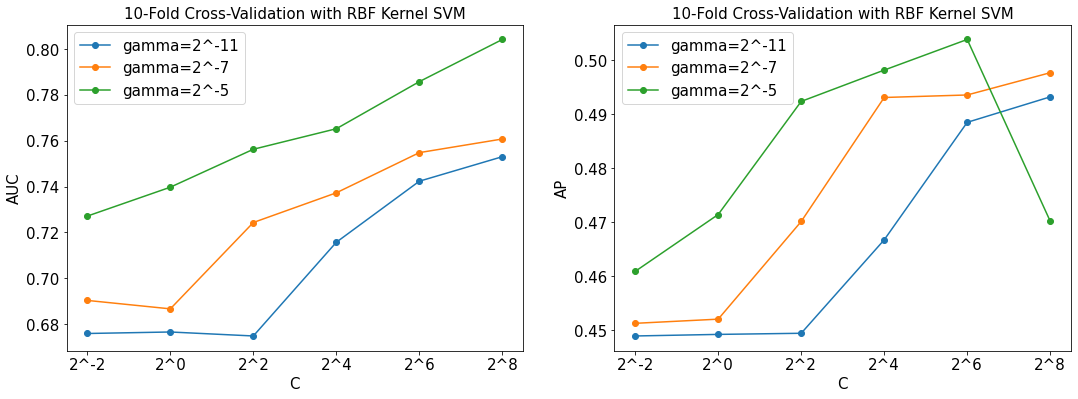

In [16]:
model.plot_auc_ap_svm(X_train_scaled, y_train, cv_fold = 10, class_weight = None)

## A-3. Random Forest

In [27]:
rf_clf = RandomForestClassifier(random_state = 42)                         
model.eval_metrics_cv(rf_clf, X_train_scaled, y_train, cv_fold = 10, scoring = 'accuracy', 
                      model_nm = "Random Forest Classifier")

10-Fold cross-validation results for Random Forest Classifier
------------------------------------------------------------
Accuracy (std): 0.990401 (0.001326)
AUROC: 0.829260
AUPRC: 0.532891
Predicted classes: [0 1]
Confusion matrix:
 [[7990    1]
 [  77   58]]
Classification report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      7991
           1       0.98      0.43      0.60       135

    accuracy                           0.99      8126
   macro avg       0.99      0.71      0.80      8126
weighted avg       0.99      0.99      0.99      8126

------------------------------------------------------------


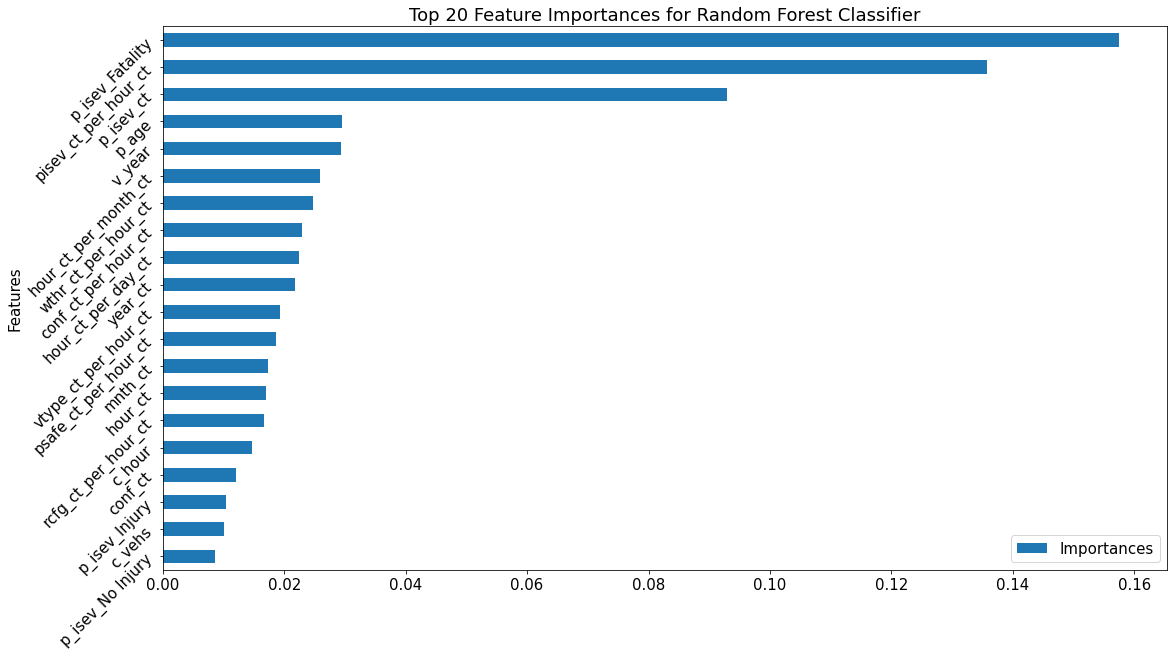

In [28]:
# Compute feature importances
importances_df = pd.DataFrame({'Features': feat_names, 
                                'Importances': rf_clf.feature_importances_
                                })
# Bar plot
importances_df.sort_values('Importances', ascending = True, inplace = True)
importances_df.set_index('Features', inplace = True)
importances_df.tail(20).plot(kind='barh', figsize = (18,10))
plt.yticks(rotation = 45)
plt.title('Top 20 Feature Importances for Random Forest Classifier')
plt.show()

## A-3-1.  Hyperparameter tuning - RF

In [29]:
# Range of hyperparameters
params = {'max_features': [0.5, 1, 'sqrt', 'log2', None],
          'max_depth': range(2,8,1),
          'min_samples_split': range(2,10,1),
          'class_weight': ['balanced', None, {0: 1, 1: class_ratio}]
                         }

# Randomized search
rf_clf = RandomForestClassifier(n_estimators = 1000, random_state = 42)           
rsearch_rf = RandomizedSearchCV(estimator = rf_clf, param_distributions = params, 
                                scoring = 'roc_auc', cv = 10, n_jobs = -1, n_iter = 200, 
                                random_state = 42, verbose = 1)  
# Fit the  training set                                                    
rsearch_rf.fit(X_train_scaled, y_train)

# Pickle trained model
joblib.dump(rsearch_rf.best_estimator_, '../src/model/rf_clf.pkl')

# Print results
print('Randomized search best AUC score:', rsearch_rf.best_score_) 
print('Randomized search best hyperparameters:', rsearch_rf.best_params_) 

Fitting 10 folds for each of 200 candidates, totalling 2000 fits
Randomized search best AUC score: 0.8828230592155029
Randomized search best hyperparameters: {'min_samples_split': 3, 'max_features': 0.5, 'max_depth': 3, 'class_weight': None}


## A-4. XGBoost

In [30]:
param_dist = {'objective':'binary:logistic', 'eval_metric':'logloss', 
              'learning_rate':0.05, 'random_state':42,'n_jobs':-1,
               'n_estimators':100
              }
              
xgb_clf = xgb.XGBClassifier(**param_dist)
model.eval_metrics_cv(xgb_clf, X_train_scaled, y_train, cv_fold = 10, scoring = 'accuracy',
                      model_nm = "XGBoost Classifier")

10-Fold cross-validation results for XGBoost Classifier
------------------------------------------------------------
Accuracy (std): 0.990278 (0.001398)
AUROC: 0.854829
AUPRC: 0.537898
Predicted classes: [0 1]
Confusion matrix:
 [[7989    2]
 [  77   58]]
Classification report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      7991
           1       0.97      0.43      0.59       135

    accuracy                           0.99      8126
   macro avg       0.98      0.71      0.79      8126
weighted avg       0.99      0.99      0.99      8126

------------------------------------------------------------


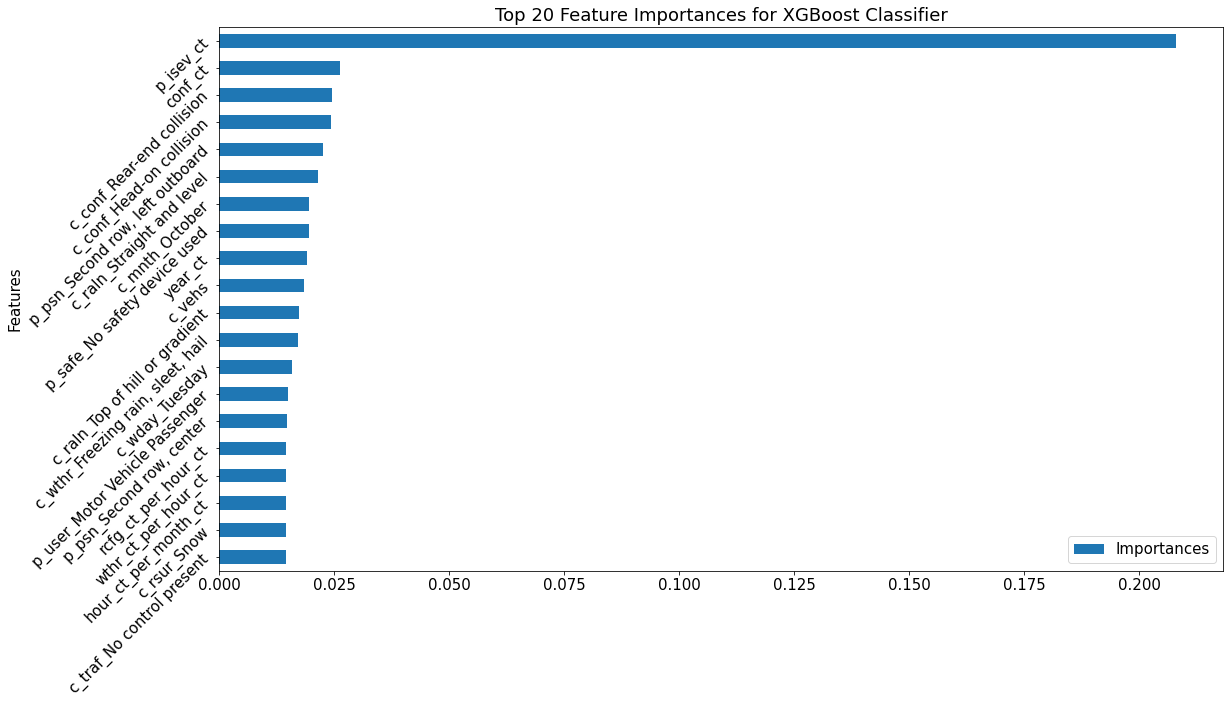

In [31]:
# Compute feature importances
importances_df = pd.DataFrame({'Features': feat_names,
                               'Importances': xgb_clf.feature_importances_
                               })
# Bar plot
importances_df.sort_values('Importances', ascending = True, inplace = True)
importances_df.set_index('Features', inplace = True)
importances_df.tail(20).plot(kind='barh', figsize = (18,10))
plt.yticks(rotation = 45)
plt.title('Top 20 Feature Importances for XGBoost Classifier')
plt.show()

## A-4-1. Hyperparameter tuning  - XGB

In [32]:
# Range of hyperparameters
params = {'max_depth': range(1,10,2), 
          'min_child_weight': range(1,6,2),
          'gamma':[i/100 for i in range(0,6)],
          'subsample':[i/10 for i in range(5,9)],
          'colsample_bytree': [i/10 for i in range(5,9)],
          'learning_rate': [0.01, 0.02, 0.05, 0.1]
          }

# Randomized search
param_dist = {'objective':'binary:logistic', 'eval_metric':'logloss', 'n_estimators':100,
              'scale_pos_weight':class_ratio, 'random_state':42
            }     
xgb_clf = xgb.XGBClassifier(**param_dist)
rsearch_xgb = RandomizedSearchCV(estimator = xgb_clf, param_distributions = params, 
                                  scoring = 'roc_auc', cv = 10, n_jobs = -1, n_iter = 200, 
                                  random_state = 42, verbose = 1)   
# Fit the  training set                                                            
rsearch_xgb.fit(X_train_scaled, y_train)

# Pickle trained model
joblib.dump(rsearch_xgb.best_estimator_, '../src/model/xgb_clf.pkl')

# Print results
print('Randomized search best AUC score:', rsearch_xgb.best_score_) 
print('Randomized search best hyperparameters:', rsearch_xgb.best_params_) 

Fitting 10 folds for each of 200 candidates, totalling 2000 fits
Randomized search best AUC score: 0.8674611224195079
Randomized search best hyperparameters: {'subsample': 0.6, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 0.04, 'colsample_bytree': 0.5}


## 5. LGBM

In [33]:
param_dict = {'boosting_type':'gbdt', 'num_leaves':31, 'max_depth':- 1, 
              'learning_rate':0.05, 'n_estimators':100, 'random_state':42
             }
              
lgb_clf = lgb.LGBMClassifier(**param_dict)
model.eval_metrics_cv(lgb_clf, X_train_scaled, y_train, cv_fold = 10, model_nm = 'LGBM Classifier')

10-Fold cross-validation results for LGBM Classifier
------------------------------------------------------------
Accuracy (std): 0.990524 (0.001462)
AUROC: 0.847381
AUPRC: 0.518461
Predicted classes: [0 1]
Confusion matrix:
 [[7990    1]
 [  76   59]]
Classification report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      7991
           1       0.98      0.44      0.61       135

    accuracy                           0.99      8126
   macro avg       0.99      0.72      0.80      8126
weighted avg       0.99      0.99      0.99      8126

------------------------------------------------------------


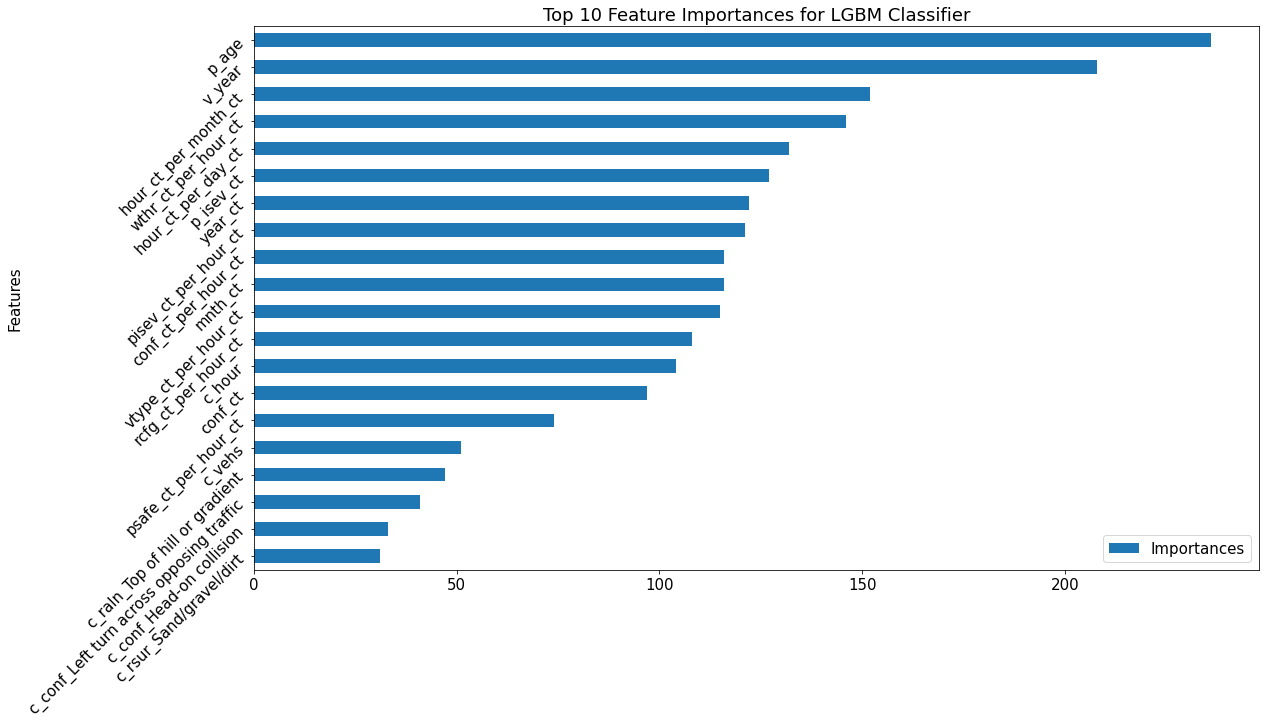

In [34]:
# Compute feature importances
importances_df = pd.DataFrame({'Features': feat_names, 
                               'Importances': lgb_clf.feature_importances_
                              })
# Plot
importances_df.sort_values('Importances', ascending = True, inplace = True)
importances_df.set_index('Features', inplace = True)
importances_df.tail(20).plot(kind='barh', figsize = (18,10))
plt.yticks(rotation = 45)
plt.title('Top 10 Feature Importances for LGBM Classifier')
# plt.savefig('../image/lgbm.png')

## A-5-1. Hyperparameter tuning  - LGBM

In [35]:
# Hyperparameter range
params = {'max_depth': [-1,30,40],
          'num_leaves': range(80,120,10),
          'min_child_samples': range(20,50,10),
          'learning_rate': [0.01, 0.02, 0.05, 0.1]
          }

# Randomized search
param_dict = {'boosting_type':'gbdt', 
              'n_estimators':100, 'random_state':42,
              'scale_pos_weight':class_ratio
             }
             
lgb_clf =  lgb.LGBMClassifier(**param_dict)                       
rsearch_lgbm = RandomizedSearchCV(estimator = lgb_clf, param_distributions = params, 
                                n_iter = 200,scoring = 'roc_auc', cv = 10, 
                                n_jobs = -1, random_state = 42, verbose = 1
                                 )  
# Fit model
rsearch_lgbm.fit(X_train_scaled, y_train)

# Pickle trained model
joblib.dump(rsearch_lgbm.best_estimator_, '../src/model/lgb_clf.pkl')

# Print results
print('Randomized search best AUC score:', rsearch_lgbm.best_score_) 
print('Best hyperparameters:', rsearch_lgbm.best_params_) 

Fitting 10 folds for each of 144 candidates, totalling 1440 fits
Randomized search best AUC score: 0.8440733850004815
Best hyperparameters: {'num_leaves': 80, 'min_child_samples': 30, 'max_depth': -1, 'learning_rate': 0.05}


In [17]:
# Load trained model
log_clf = joblib.load('../src/model/log_clf.pkl')
svm_clf = joblib.load('../src/model/svm_clf.pkl')
rf_clf = joblib.load('../src/model/rf_clf.pkl')
xgb_clf = joblib.load('../src/model/xgb_clf.pkl')
lgb_clf = joblib.load('../src/model/lgb_clf.pkl')

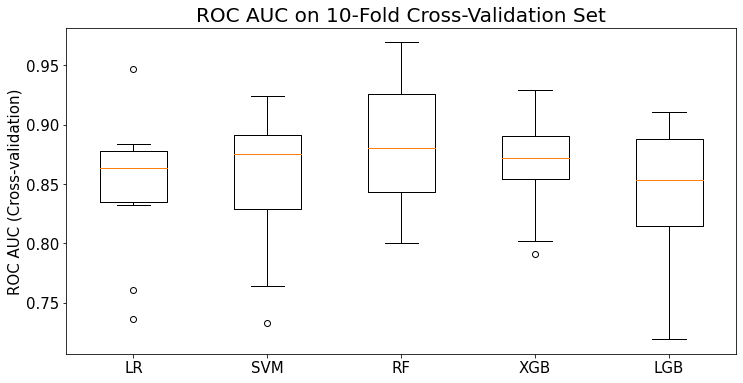

In [18]:
model_dict = {'LR': log_clf, 'SVM': svm_clf, 'RF': rf_clf, 'XGB': xgb_clf, 'LGB': lgb_clf}
roc_scores = []

for i, (name, model_) in enumerate(model_dict.items()):
    score = cross_val_score(model_, X_train_scaled, y_train, cv = 10, scoring = 'roc_auc')
    roc_scores.append(score)

plt.figure(figsize = (12,6))
plt.boxplot(roc_scores)
plt.xticks(np.arange(len(model_dict))+1, list(model_dict.keys()))
plt.title('ROC AUC on 10-Fold Cross-Validation Set', fontsize = 20)
plt.ylabel('ROC AUC (Cross-validation)')
plt.savefig('../image/cv_metric.png')
plt.show()

# C. Resampling Methods
In this section, we will employ two resampling techniques on the training set to balance the classes. However, the final prediction will be made on the imbalanced test set. The idea of resampling is to trick the classifier using a balanced dataset.  

## C-1. Under Sampling  combined with Random Forest Classifier
In undersampling, we reduce the majority class such that it matches the minority class

In [16]:
# Under sample the majority class
und = RandomUnderSampler(random_state = 42)
X_train_scaled_und, y_train_und = und.fit_resample(X_train_scaled, y_train)

In [17]:
print('Undersampled training data size:', X_train_scaled_und.shape, y_train_und.shape)

Undersampled training data size: (270, 153) (270,)


In [18]:
print('Imbalanced training set class distribution:', np.bincount(y_train))
print('Undersampled training set class distribution:', np.bincount(y_train_und))

Imbalanced training set class distribution: [7991  135]
Undersampled training set class distribution: [135 135]


In [19]:
# Random Forest Classifier cross-validation on the undersampled dataset
param_dist = {'n_estimators':100, 'random_state':42,'n_jobs':-1}   
rf_und = RandomForestClassifier(**param_dist)

model.eval_metrics_cv(rf_und, X_train_scaled_und, y_train_und, cv_fold = 10, 
scoring = 'accuracy', model_nm = "Undersampling with Random Forest Classifier")

10-Fold cross-validation results for Undersampling with Random Forest Classifier
------------------------------------------------------------
Accuracy (std): 0.796296 (0.037952)
AUROC: 0.868450
AUPRC: 0.896998
Predicted classes: [0 1]
Confusion matrix:
 [[116  19]
 [ 36  99]]
Classification report:
               precision    recall  f1-score   support

           0       0.76      0.86      0.81       135
           1       0.84      0.73      0.78       135

    accuracy                           0.80       270
   macro avg       0.80      0.80      0.80       270
weighted avg       0.80      0.80      0.80       270

------------------------------------------------------------


## C-2. SMOTE  combined with Random Forest Classifier
In Synthetic Minority Over Sampling Technique (SMOTE), we generate synthetic oberservations to match the minority clas.
SMOTE oversampled the minority class in the training set, so we now have equal class distribution. 

In [20]:
# Over sample the minority class
sm = SMOTE(random_state = 42)
X_train_scaled_ovsm, y_train_ovsm = sm.fit_resample(X_train_scaled, y_train)

In [21]:
print('SMOTE training data size:', X_train_scaled_ovsm.shape, y_train_ovsm.shape)

SMOTE training data size: (15982, 153) (15982,)


In [22]:
print('Imbalanced training set class distribution:', np.bincount(y_train))
print('SMOTE resampled training set class distribution:', np.bincount(y_train_ovsm))

Imbalanced training set class distribution: [7991  135]
SMOTE resampled training set class distribution: [7991 7991]


In [23]:
# XGBoost cross-validation on the SMOTE dataset
param_dist =  {'n_estimators':100, 'random_state':42,'n_jobs':-1}  
rf_ovsm = RandomForestClassifier(**param_dist)

model.eval_metrics_cv(rf_ovsm, X_train_scaled_ovsm, y_train_ovsm, cv_fold = 10, 
scoring = 'accuracy', model_nm = "SMOTE with Random Forest Classifier")

10-Fold cross-validation results for SMOTE with Random Forest Classifier
------------------------------------------------------------
Accuracy (std): 0.995747 (0.011729)
AUROC: 0.999928
AUPRC: 0.999924
Predicted classes: [0 1]
Confusion matrix:
 [[7986    5]
 [  63 7928]]
Classification report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      7991
           1       1.00      0.99      1.00      7991

    accuracy                           1.00     15982
   macro avg       1.00      1.00      1.00     15982
weighted avg       1.00      1.00      1.00     15982

------------------------------------------------------------


# D. Prediction on the Imbalanced Test Set 
In this section, we make our final prediction on the imbalanced dataset after training the model using the resampling techniques.

## D-1. Normal Imbalanced Dataset

In [15]:
model.test_pred(rf_clf, X_test_scaled, y_test, model_nm = "XGBoost Classifier")

Test predictions for XGBoost Classifier
------------------------------------------------------------
Accuracy:  0.990650
AUROC: 0.885591
AUPRC: 0.553930
Predicted classes: [0 1]
Confusion matrix:
 [[1998    0]
 [  19   15]]
Classification report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      1998
           1       1.00      0.44      0.61        34

    accuracy                           0.99      2032
   macro avg       1.00      0.72      0.80      2032
weighted avg       0.99      0.99      0.99      2032

------------------------------------------------------------


## D-2. Undersampled Dataset

In [24]:
model.test_pred(rf_und, X_test_scaled, y_test,
                model_nm = "UnderSampling with Random Forest Classifier")

Test predictions for UnderSampling with Random Forest Classifier
------------------------------------------------------------
Accuracy:  0.838583
AUROC: 0.886261
AUPRC: 0.416276
Predicted classes: [0 1]
Confusion matrix:
 [[1677  321]
 [   7   27]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.84      0.91      1998
           1       0.08      0.79      0.14        34

    accuracy                           0.84      2032
   macro avg       0.54      0.82      0.53      2032
weighted avg       0.98      0.84      0.90      2032

------------------------------------------------------------


## D-3. SMOTE Dataset

In [25]:
model.test_pred(rf_ovsm, X_test_scaled, y_test,
                model_nm = "SMOTE with Random Forest Classifier")

Test predictions for SMOTE with Random Forest Classifier
------------------------------------------------------------
Accuracy:  0.989173
AUROC: 0.890854
AUPRC: 0.541209
Predicted classes: [0 1]
Confusion matrix:
 [[1995    3]
 [  19   15]]
Classification report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      1998
           1       0.83      0.44      0.58        34

    accuracy                           0.99      2032
   macro avg       0.91      0.72      0.79      2032
weighted avg       0.99      0.99      0.99      2032

------------------------------------------------------------


# E.  ROC and PR Curves


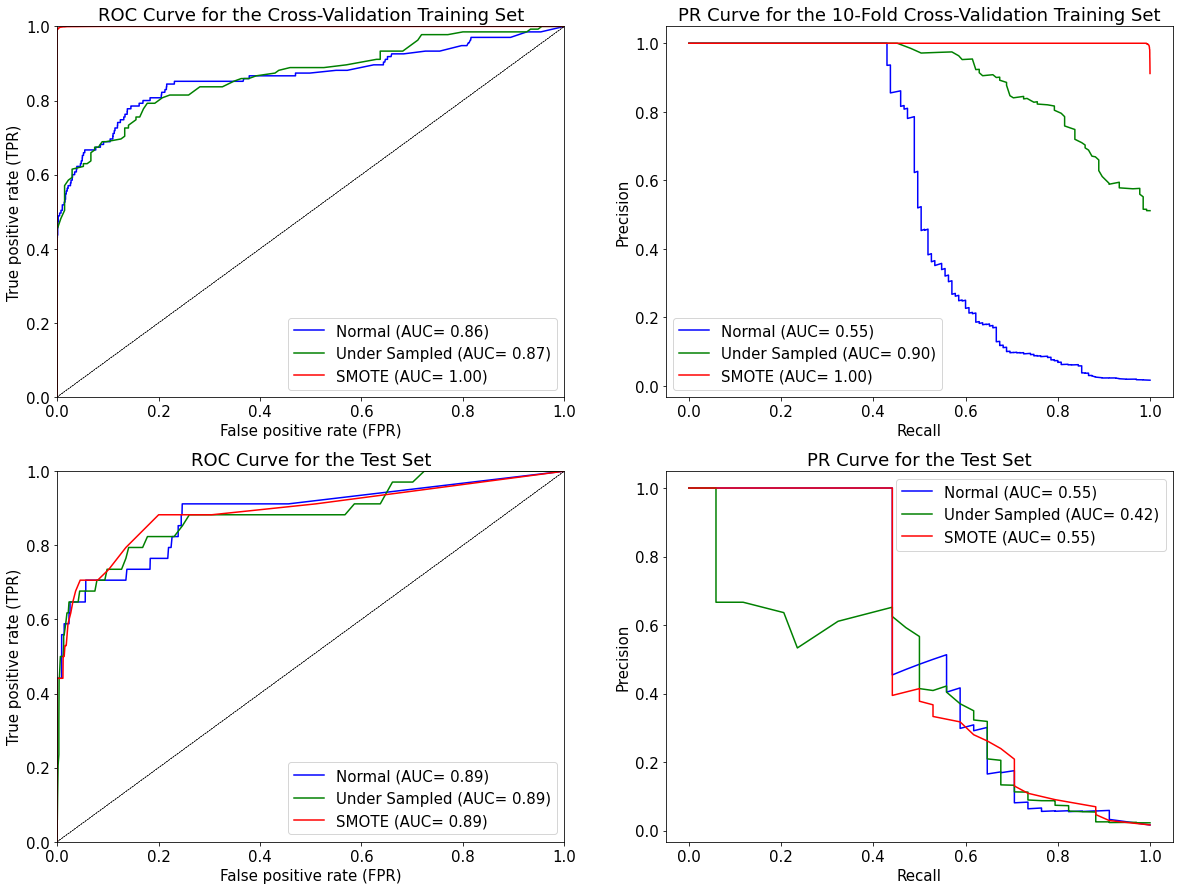

In [26]:
plt.figure(figsize = (20,15))

# Normal imbalanced distribution
model.plot_roc_pr_curves(rf_clf, X_train_scaled, y_train, X_test_scaled, y_test, cv_fold = 10,
                       color= 'b', label = 'Normal (AUC= %0.2f)')

# Under Sampled distribution
model.plot_roc_pr_curves(rf_und, X_train_scaled_und, y_train_und, X_test_scaled, y_test, cv_fold = 10, color= 'g', label = 'Under Sampled (AUC= %0.2f)')
                     
# SMOTE distribution
model.plot_roc_pr_curves(rf_ovsm, X_train_scaled_ovsm, y_train_ovsm, X_test_scaled, y_test, cv_fold = 10, color= 'r', label = 'SMOTE (AUC= %0.2f)') 

# F. AUC-ROC and AUC-PR for Cross-Validation vs. Test Sets

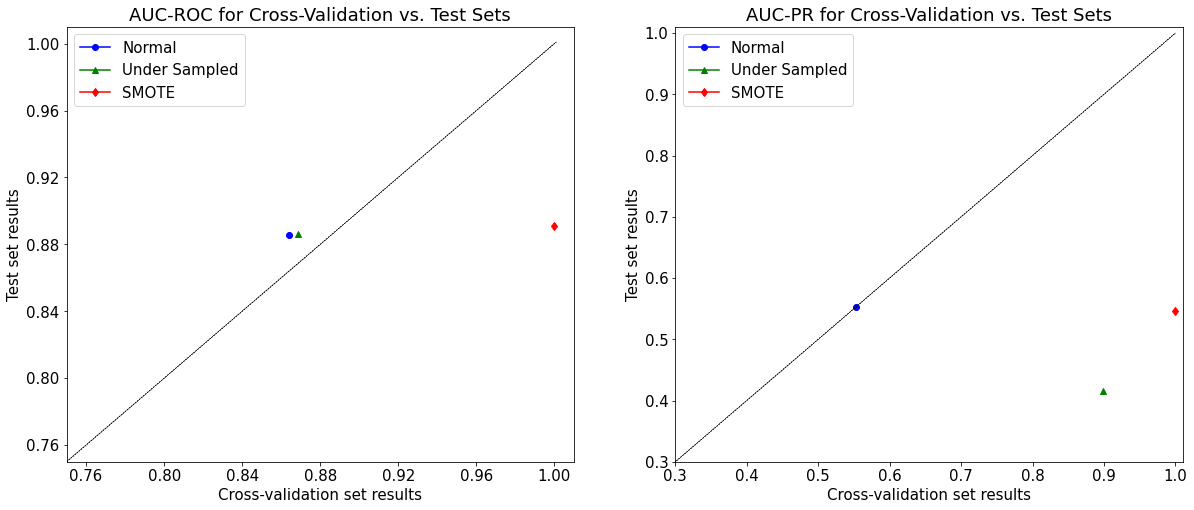

In [27]:
plt.figure(figsize = (20,8))

# Normal imbalanced distribution
model.plot_aucroc_aucpr(rf_clf, X_train_scaled, y_train, X_test_scaled, y_test, cv_fold = 10,
                       marker = 'o', color= 'b', label = 'Normal')

# Under Sampled distribution
model.plot_aucroc_aucpr(rf_und, X_train_scaled_und, y_train_und, X_test_scaled, y_test, cv_fold = 10, marker = '^', color= 'g', label = 'Under Sampled')
                     
# SMOTE distribution
model.plot_aucroc_aucpr(rf_ovsm, X_train_scaled_ovsm, y_train_ovsm, X_test_scaled, y_test, cv_fold = 10, marker = 'd', color= 'r', label = 'SMOTE') 